## VGG16 Transfer Learning

In [2]:
# Import TensorFlow library for building and training deep learning models
import tensorflow as tf

# Import the pre-trained VGG16 model from Keras applications
# This model is trained on ImageNet and can be used for transfer learning
from tensorflow.keras.applications import VGG16

# Import Keras modules for layers and model creation
# layers: to add Dense, Flatten, Dropout etc.
# models: to create Sequential or Functional API models
from tensorflow.keras import layers, models

# Import ImageDataGenerator for loading and augmenting image data
# Allows transformations like rotation, flipping, zooming to improve generalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import OS module to handle directory paths and file operations
import os

# Import zipfile module to extract zip files
# Useful for datasets downloaded in compressed format
import zipfile

In [3]:
# --------------------------------------------------
# Step 0: Download the Cats vs Dogs dataset and extract it

# URL of the Cats vs Dogs dataset (zip file)
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

In [4]:
# Download the dataset using TensorFlow's utility function
# tf.keras.utils.get_file downloads the file from the URL to a local cache directory
# 'cats_and_dogs.zip' is the filename to save
# extract=False means we will manually extract the zip later
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=False)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Extract the zip file to a folder

# Create the path where the dataset will be extracted
# os.path.dirname(zip_path) gets the directory of the downloaded zip
# 'cats_and_dogs_filtered' is the folder name where files will be extracted
extract_dir = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')

In [6]:
# Open the zip file in read mode
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all files from the zip into the specified folder
    zip_ref.extractall(extract_dir)

In [7]:
extract_dir


'/root/.keras/datasets/cats_and_dogs_filtered'

In [8]:
zip_ref

<zipfile.ZipFile [closed]>

In [9]:
# Define train and validation directories

# Path to the training images folder
# Combines the extraction directory, dataset folder, and 'train' subfolder
train_dir = os.path.join(extract_dir, 'cats_and_dogs_filtered', 'train')

In [10]:
# Path to the validation images folder
# Combines the extraction directory, dataset folder, and 'validation' subfolder
validation_dir = os.path.join(extract_dir, 'cats_and_dogs_filtered', 'validation')

In [11]:
# --------------------------------------------------
# Step 1: Load Pre-trained VGG16 Model (without top layers)

# Load the VGG16 model with pre-trained ImageNet weights
# weights='imagenet' means we use the weights trained on ImageNet dataset
# include_top=False means we exclude the fully connected (classification) layers at the top
# input_shape=(224,224,3) specifies the input image size and 3 color channels (RGB)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# --------------------------------------------------
# Step 2: Freeze all layers of the pre-trained model

# Loop through each layer in the base VGG16 model
for layer in base_model.layers:
    # Set layer.trainable = False to freeze the weights during training
    # This preserves the pre-trained features and prevents them from being updated
    layer.trainable = False

In [13]:
# --------------------------------------------------
# Step 3: Add custom layers on top

# Create a new Sequential model by stacking layers
model = models.Sequential([
    base_model,                       # Add the frozen VGG16 base model first
    layers.Flatten(),                  # Flatten the 3D feature maps to 1D vector
    layers.Dense(256, activation='relu'), # Add a Dense layer with 256 neurons and ReLU activation
    layers.Dropout(0.5),               # Add Dropout to reduce overfitting (50% of neurons ignored per update)
    layers.Dense(2, activation='softmax') # Final output layer with 2 neurons for 2 classes (cats and dogs)
])

In [14]:
# --------------------------------------------------
# Step 4: Compile the model

# Compile the model before training
# optimizer='adam' -> Adam optimizer is efficient and widely used
# loss='categorical_crossentropy' -> suitable for multi-class classification
# metrics=['accuracy'] -> monitor accuracy during training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# --------------------------------------------------
# Step 5: Prepare Image Data

# Create a training ImageDataGenerator for data augmentation
# This will generate batches of image data with transformations applied
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0,1] range
    rotation_range=40,       # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Random shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformation
)

In [16]:
# Validation data generator (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# Create training data generator from directory
# Automatically labels images based on folder names
train_generator = train_datagen.flow_from_directory(
    train_dir,               # Path to training images
    target_size=(224,224),   # Resize images to 224x224 (VGG16 input)
    batch_size=32,           # Number of images per batch
    class_mode='categorical' # Multi-class labels
)

Found 2000 images belonging to 2 classes.


In [18]:
# Create validation data generator from directory
validation_generator = val_datagen.flow_from_directory(
    validation_dir,          # Path to validation images
    target_size=(224,224),   # Resize images
    batch_size=32,           # Batch size
    class_mode='categorical' # Multi-class labels
)

Found 1000 images belonging to 2 classes.


In [19]:
# --------------------------------------------------
# Step 6: Train the model

# Train the model using the training generator
# steps_per_epoch = total training samples / batch size
# validation_steps = total validation samples / batch size
# epochs = number of complete passes over the dataset
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 56s 662ms/step - accuracy: 0.6079 - loss: 1.2768 - val_accuracy: 0.8720 - val_loss: 0.3166
Epoch 2/5
 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8438 - loss: 0.3947

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8438 - loss: 0.3947 - val_accuracy: 0.8710 - val_loss: 0.3098
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 531ms/step - accuracy: 0.8139 - loss: 0.4167 - val_accuracy: 0.8982 - val_loss: 0.2661
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6875 - loss: 0.5650 - val_accuracy: 0.8992 - val_loss: 0.2647
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 625ms/step - accuracy: 0.8277 - loss: 0.3845 - val_accuracy: 0.9052 - val_loss: 0.2434


In [20]:
# --------------------------------------------------
# Optional Step 7: Fine-tuning last layers

# Unfreeze the last 4 layers of the VGG16 base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True  # Allow these layers to update during training

In [21]:
# Re-compile the model with a smaller learning rate for fine-tuning
# Small learning rate ensures pre-trained weights are not drastically changed
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model for additional epochs
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5
)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.8469 - loss: 0.3510 - val_accuracy: 0.9284 - val_loss: 0.1758
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.7500 - loss: 0.4165 - val_accuracy: 0.9315 - val_loss: 0.1782
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 536ms/step - accuracy: 0.8954 - loss: 0.2541 - val_accuracy: 0.9435 - val_loss: 0.1456
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8438 - loss: 0.3760 - val_accuracy: 0.9466 - val_loss: 0.1452
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 72s 544ms/step - accuracy: 0.9155 - loss: 0.2233 - val_accuracy: 0.9516 - val_loss: 0.1405


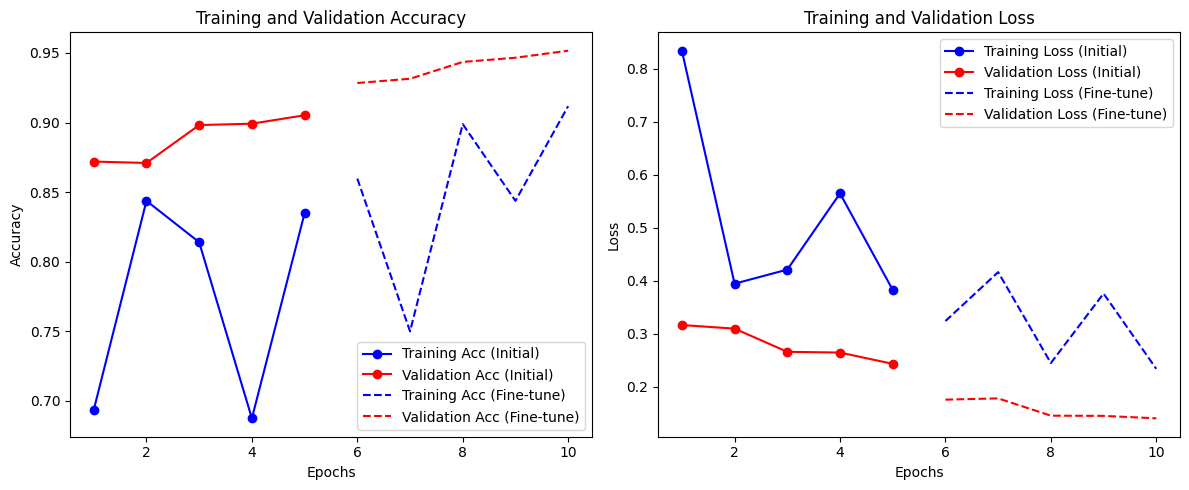

In [22]:
import matplotlib.pyplot as plt

# Extract metrics from initial training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract metrics from fine-tuning
acc_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']
loss_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

# Combine metrics for plotting
epochs_initial = range(1, len(acc)+1)
epochs_fine = range(len(acc)+1, len(acc)+len(acc_fine)+1)

# Plot Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_initial, acc, 'b-o', label='Training Acc (Initial)')
plt.plot(epochs_initial, val_acc, 'r-o', label='Validation Acc (Initial)')
plt.plot(epochs_fine, acc_fine, 'b--', label='Training Acc (Fine-tune)')
plt.plot(epochs_fine, val_acc_fine, 'r--', label='Validation Acc (Fine-tune)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs_initial, loss, 'b-o', label='Training Loss (Initial)')
plt.plot(epochs_initial, val_loss, 'r-o', label='Validation Loss (Initial)')
plt.plot(epochs_fine, loss_fine, 'b--', label='Training Loss (Fine-tune)')
plt.plot(epochs_fine, val_loss_fine, 'r--', label='Validation Loss (Fine-tune)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Step 1: Load new image (replace 'new_image.jpg' with your image path)
img_path = "/content/images2.jpeg"
img = image.load_img(img_path, target_size=(224,224))  # Resize to VGG16 input size

# Step 2: Convert image to array
img_array = image.img_to_array(img)

# Step 3: Expand dims to make it batch size 1 (model expects 4D input)
img_array = np.expand_dims(img_array, axis=0)

# Step 4: Normalize (same as training)
img_array /= 255.0

# Step 5: Predict
pred = model.predict(img_array)

# Step 6: Convert prediction to label
class_indices = train_generator.class_indices   # {'cats': 0, 'dogs': 1}
labels = {v:k for k,v in class_indices.items()} # Reverse mapping

pred_class = labels[np.argmax(pred)]
print("Predicted class:", pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: cats


## **VGG19**

In [ ]:
# -------------------------------
# VGG19 Transfer Learning - Cats vs Dogs
# -------------------------------

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array  # Correct import for TF >=2.11
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

# --------------------------------------------------
# Step 0: Download Cats vs Dogs dataset and extract
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=False)

extract_dir = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

train_dir = os.path.join(extract_dir, 'cats_and_dogs_filtered', 'train')
validation_dir = os.path.join(extract_dir, 'cats_and_dogs_filtered', 'validation')

# --------------------------------------------------
# Step 1: Load Pre-trained VGG19 Model (without top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

# --------------------------------------------------
# Step 2: Freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# --------------------------------------------------
# Step 3: Add custom layers on top
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Output: 2 classes (cats, dogs)
])

# --------------------------------------------------
# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --------------------------------------------------
# Step 5: Prepare Image Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# --------------------------------------------------
# Step 6: Train the model (initial training)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5
)

# --------------------------------------------------
# Optional Step 7: Fine-tuning last layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=5
)

# --------------------------------------------------
# Step 8: Accuracy and Loss Comparison Visualisation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']
loss_fine = history_fine.history['loss']
val_loss_fine = history_fine.history['val_loss']

epochs_initial = range(1, len(acc)+1)
epochs_fine = range(len(acc)+1, len(acc)+len(acc_fine)+1)

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs_initial, acc, 'b-o', label='Training Acc (Initial)')
plt.plot(epochs_initial, val_acc, 'r-o', label='Validation Acc (Initial)')
plt.plot(epochs_fine, acc_fine, 'b--', label='Training Acc (Fine-tune)')
plt.plot(epochs_fine, val_acc_fine, 'r--', label='Validation Acc (Fine-tune)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs_initial, loss, 'b-o', label='Training Loss (Initial)')
plt.plot(epochs_initial, val_loss, 'r-o', label='Validation Loss (Initial)')
plt.plot(epochs_fine, loss_fine, 'b--', label='Training Loss (Fine-tune)')
plt.plot(epochs_fine, val_loss_fine, 'r--', label='Validation Loss (Fine-tune)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --------------------------------------------------
# Step 9: Predict on new images

# Create reverse mapping of class indices
class_indices = train_generator.class_indices   # {'cats':0, 'dogs':1}
labels = {v:k for k,v in class_indices.items()}

def predict_image(img_path):
    """Predict class of a single image"""
    img = load_img(img_path, target_size=(224,224))   # Load and resize image
    img_array = img_to_array(img)                     # Convert to array
    img_array = np.expand_dims(img_array, axis=0)/255.0  # Add batch dim and normalize
    pred = model.predict(img_array)
    pred_class = labels[np.argmax(pred)]
    print(f"Predicted class for {os.path.basename(img_path)}: {pred_class}")

# Example usage
# predict_image('new_image.jpg')  # Replace with your own image path
